# DeepLabCut Test Notebook for Data Visualization

The objective of this notebook is to figure out how to read, handle, and visualize DLC data so that we can "quantify" the behavior of mice and compare WT to disease models.

In [1]:
# handling data
import pandas as pd
import numpy as np
import openpyxl

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

# Statistics
from scipy import stats
import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.imputation.mice import MICEData
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value Stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#Extras
from utils import *
import math

#Time data stuff, neural network stuff?
import time
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime


#Data processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#ML models
import xgboost as xgb
import catboost as ctb


print("Setup Complete")

Setup Complete


In [2]:
pwd


'/Users/aidanlew/DLC'

In [3]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


# Setting Up the Data

In [4]:
cage1_df=pd.read_csv('../Documents/WT_test_DLC_data/cage1_WT_social_trial.csv',
                             #skiprows=1
                             )
cage1_df.tail()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
27167,1342.095,700.735,1363.636,647.077,1317.101,643.423,1270.105,495.641,1395.500,314.658,...,1186.090,320.832,1349.596,753.617,1285.402,683.352,1247.582,742.086,1143.317,626.914
27168,1342.095,700.776,1363.636,651.323,1317.101,652.958,1270.178,495.641,1397.254,323.956,...,1185.048,317.352,1355.892,753.713,1285.423,681.006,1250.004,742.654,1143.534,626.914
27169,1364.987,746.607,1363.636,655.785,1317.178,658.402,1271.027,495.935,NaN,NaN,...,1184.391,308.591,NaN,NaN,1291.029,680.828,1258.683,742.654,1143.534,626.656
27170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,...,1180.007,306.537,0.000,0.000,1291.029,665.459,1258.683,742.654,1143.534,625.968
27171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,...,1179.130,301.175,0.000,0.000,1291.029,664.407,1258.683,740.314,1143.534,624.650


In [5]:
cage2_df=pd.read_csv('../Documents/WT_test_DLC_data/cage2_WT_social_trial.csv',
                             #skiprows=1
                             )
cage2_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,497.769,72.606,509.462,177.486,561.649,154.056,0.000,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,498.041,72.606,509.735,177.486,563.096,154.056,0.000,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,498.166,72.606,512.856,177.486,563.307,154.056,643.153,321.144,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,499.519,69.820,512.856,171.235,563.307,149.104,646.904,322.845,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,500.297,68.648,515.115,170.533,564.074,149.104,646.909,331.380,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
cage3_df=pd.read_csv('../Documents/WT_test_DLC_data/cage3_WT_social_trial.csv',
                             #skiprows=1
                             )
cage3_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,539.203,204.918,553.853,229.809,NaN,NaN,751.054,279.378,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,539.353,204.918,554.441,231.186,NaN,NaN,752.696,281.245,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,539.773,204.918,555.277,233.216,NaN,NaN,752.737,281.776,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,539.353,204.866,562.306,234.649,590.615,203.907,753.996,281.776,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,539.203,199.427,563.335,236.173,593.898,204.736,755.096,281.409,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
cage4_df=pd.read_csv('../Documents/WT_test_DLC_data/cage4_WT_social_trial.csv',
                             #skiprows=1
                             )
cage4_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,0.000,0.000,501.775,581.191,476.366,526.956,597.314,491.645,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000,0.000,507.167,588.375,476.366,527.976,597.716,491.645,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,395.202,603.233,508.330,594.290,479.962,538.880,599.645,491.645,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,408.871,632.174,515.748,595.114,479.962,545.327,602.107,489.998,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,420.199,635.113,524.240,595.114,480.436,547.748,608.921,486.761,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
cage5_df=pd.read_csv('../Documents/WT_test_DLC_data/cage5_WT_social_trial.csv',
                             #skiprows=1
                             )
cage5_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,NaN,NaN,494.351,389.680,451.906,352.392,535.404,210.554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,496.921,389.816,454.478,352.491,535.477,210.820,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,497.215,391.690,455.351,352.597,535.534,210.935,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,497.228,393.695,456.235,353.395,535.534,211.095,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,497.228,395.461,456.300,355.110,535.477,211.761,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
cage1_df
cage2_df
cage3_df
cage4_df
cage5_df

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,NaN,NaN,494.351,389.680,451.906,352.392,535.404,210.554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,496.921,389.816,454.478,352.491,535.477,210.820,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,497.215,391.690,455.351,352.597,535.534,210.935,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,497.228,393.695,456.235,353.395,535.534,211.095,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,497.228,395.461,456.300,355.110,535.477,211.761,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27113,1348.296,596.200,1351.267,545.008,1317.055,571.222,1192.301,418.778,922.299,457.562,...,921.506,637.325,1024.801,557.431,1046.648,481.700,977.951,499.265,986.899,379.111
27114,1340.571,606.132,1351.267,554.195,1316.985,575.964,1193.873,418.778,922.299,458.709,...,915.811,634.432,1024.801,559.418,1045.372,483.578,976.268,498.387,987.507,379.028
27115,1336.873,612.738,1351.069,561.982,1314.513,581.852,1195.020,418.778,924.585,468.653,...,903.457,629.032,1024.801,563.182,1043.730,483.578,976.268,498.387,987.617,379.028
27116,1334.262,612.738,1350.284,561.982,1313.411,581.852,1195.020,417.789,924.585,468.653,...,902.061,627.682,1023.005,563.182,1043.368,483.578,975.438,498.289,987.617,378.291


# Imputation
    - Sipmple Imputation: Basically takes the mean of the surrounding coords in the column and imputes them - doesn't factor in the other imputed values

In [10]:
### NOTE The imputer functions can't have whitespace in the column names ####
    ##Make into for loop or def, this is dirty
#Make copies so that the origional df is not altered (causing issues with the other functions that use it)
cage1_imp_df = cage1_df.copy()
cage2_imp_df = cage2_df.copy()
cage3_imp_df = cage3_df.copy()
cage4_imp_df = cage4_df.copy()
cage5_imp_df = cage5_df.copy()

#Cage1 imputations
cage1_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
cage1_Simp.fit(cage1_imp_df)
cage1_imputed_ar = cage1_Simp.transform(cage1_imp_df)
cage1_imputed_df = pd.DataFrame(cage1_imputed_ar, columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])

#Cage2 Imputations
cage2_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
cage2_Simp.fit(cage2_imp_df)
cage2_imputed_ar = cage2_Simp.transform(cage2_imp_df)
cage2_imputed_df = pd.DataFrame(cage2_imputed_ar, columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])

#Cage3 Imputations
cage3_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
cage3_Simp.fit(cage3_imp_df)
cage3_imputed_ar = cage3_Simp.transform(cage3_imp_df)
cage3_imputed_df = pd.DataFrame(cage3_imputed_ar, columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])

#Cage4 Imputations
cage4_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
cage4_Simp.fit(cage4_imp_df)
cage4_imputed_ar = cage4_Simp.transform(cage4_imp_df)
cage4_imputed_df = pd.DataFrame(cage4_imputed_ar, columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])

#Cage5 Imputations
cage5_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
cage5_Simp.fit(cage5_imp_df)
cage5_imputed_ar = cage5_Simp.transform(cage5_imp_df)
cage5_imputed_df = pd.DataFrame(cage5_imputed_ar, columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])


# Creating Averages for Markers and Mice

In [11]:
#Copy the origional df's to mitigate issues
cage1_added_df=cage1_imputed_df.copy()
cage2_added_df=cage2_imputed_df.copy()
cage3_added_df=cage3_imputed_df.copy()
cage4_added_df=cage4_imputed_df.copy()
cage5_added_df=cage5_imputed_df.copy()

cage5_added_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,873.087197,476.495562,494.351,389.680,451.906,352.392,535.404,210.554,914.410802,511.865296,...,931.047969,457.301205,848.551256,502.487783,852.87002,473.089381,834.91616,470.351743,852.776095,438.720114
1,873.087197,476.495562,496.921,389.816,454.478,352.491,535.477,210.820,914.410802,511.865296,...,931.047969,457.301205,848.551256,502.487783,852.87002,473.089381,834.91616,470.351743,852.776095,438.720114
2,873.087197,476.495562,497.215,391.690,455.351,352.597,535.534,210.935,914.410802,511.865296,...,931.047969,457.301205,848.551256,502.487783,852.87002,473.089381,834.91616,470.351743,852.776095,438.720114
3,873.087197,476.495562,497.228,393.695,456.235,353.395,535.534,211.095,914.410802,511.865296,...,931.047969,457.301205,848.551256,502.487783,852.87002,473.089381,834.91616,470.351743,852.776095,438.720114
4,873.087197,476.495562,497.228,395.461,456.300,355.110,535.477,211.761,914.410802,511.865296,...,931.047969,457.301205,848.551256,502.487783,852.87002,473.089381,834.91616,470.351743,852.776095,438.720114


In [84]:
#Find a way to make this more streamlined

# 1.)Get distance between the diff x&y coords
# 2.)Average the distances for each marker
# 3.)Average all the markers between the mice
# 4.)Make new df with the averages of all the mice

#Cage1

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice

cage1_added_df['H&U_S']= np.sqrt(((cage1_added_df['HomeMouse_Snout_x']-cage1_added_df['UnfamiliarMouse_Snout_x'])**2)+
                                   (cage1_added_df['HomeMouse_Snout_y']-cage1_added_df['UnfamiliarMouse_Snout_y'])**2)

cage1_added_df['H&U_LE']= np.sqrt(((cage1_added_df['HomeMouse_LeftEar_x']-cage1_added_df['UnfamiliarMouse_LeftEar_x'])**2)+
                                   (cage1_added_df['HomeMouse_LeftEar_y']-cage1_added_df['UnfamiliarMouse_LeftEar_y'])**2)

cage1_added_df['H&U_RE']= np.sqrt(((cage1_added_df['HomeMouse_RightEar_x']-cage1_added_df['UnfamiliarMouse_RightEar_x'])**2)+
                                   (cage1_added_df['HomeMouse_RightEar_y']-cage1_added_df['UnfamiliarMouse_RightEar_y'])**2)

cage1_added_df['H&U_TB']= np.sqrt(((cage1_added_df['HomeMouse_Tailbase_x']-cage1_added_df['UnfamiliarMouse_Tailbase_x'])**2)+
                                   (cage1_added_df['HomeMouse_Tailbase_y']-cage1_added_df['UnfamiliarMouse_Tailbase_y'])**2)
#Home and Familiar Mice
cage1_added_df['H&F_S']= np.sqrt(((cage1_added_df['HomeMouse_Snout_x']-cage1_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage1_added_df['HomeMouse_Snout_y']-cage1_added_df['FamiliarMouse_Snout_y'])**2)

cage1_added_df['H&F_LE']= np.sqrt(((cage1_added_df['HomeMouse_LeftEar_x']-cage1_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage1_added_df['HomeMouse_LeftEar_y']-cage1_added_df['FamiliarMouse_LeftEar_y'])**2)

cage1_added_df['H&F_RE']= np.sqrt(((cage1_added_df['HomeMouse_RightEar_x']-cage1_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage1_added_df['HomeMouse_RightEar_y']-cage1_added_df['FamiliarMouse_RightEar_y'])**2)

cage1_added_df['H&F_TB']= np.sqrt(((cage1_added_df['HomeMouse_Tailbase_x']-cage1_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage1_added_df['HomeMouse_Tailbase_y']-cage1_added_df['FamiliarMouse_Tailbase_y'])**2)

#Unfamiliar and Familiar Mice
cage1_added_df['U&F_S']= np.sqrt(((cage1_added_df['UnfamiliarMouse_Snout_x']-cage1_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage1_added_df['UnfamiliarMouse_Snout_y']-cage1_added_df['FamiliarMouse_Snout_y'])**2)

cage1_added_df['U&F_LE']= np.sqrt(((cage1_added_df['UnfamiliarMouse_LeftEar_x']-cage1_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage1_added_df['UnfamiliarMouse_LeftEar_y']-cage1_added_df['FamiliarMouse_LeftEar_y'])**2)

cage1_added_df['U&F_RE']= np.sqrt(((cage1_added_df['UnfamiliarMouse_RightEar_x']-cage1_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage1_added_df['UnfamiliarMouse_RightEar_y']-cage1_added_df['FamiliarMouse_RightEar_y'])**2)

cage1_added_df['U&F_TB']= np.sqrt(((cage1_added_df['UnfamiliarMouse_Tailbase_x']-cage1_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage1_added_df['UnfamiliarMouse_Tailbase_y']-cage1_added_df['FamiliarMouse_Tailbase_y'])**2)


cage1_added_df['Average_H&U'] = cage1_added_df[['H&U_S','H&U_LE','H&U_RE','H&U_TB']].mean(axis=1)
cage1_added_df['Average_H&F'] = cage1_added_df[['H&F_S','H&F_LE','H&F_RE','H&F_TB']].mean(axis=1)
cage1_added_df['Average_U&F'] = cage1_added_df[['U&F_S','U&F_LE','U&F_RE','U&F_TB']].mean(axis=1)
cage1_added_df['Experiment'] = "One"

cage1_added_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,H&U_TB,H&F_S,H&F_LE,H&F_RE,H&F_TB,U&F_S,U&F_LE,U&F_RE,U&F_TB,Experiment
0,1278.406,795.087,1300.465,698.951,1234.91,706.485,1202.579,579.544,939.123128,502.684709,...,284.262195,424.586976,397.836796,358.972020,251.826085,25.329006,25.375618,16.601531,41.396464,One
1,1278.406,796.202,1300.465,701.670,1234.91,707.821,1202.579,579.544,939.123128,502.684709,...,284.262195,425.296378,399.127162,359.724534,251.826085,25.329006,25.375618,16.601531,41.396464,One
2,1278.406,796.731,1300.465,702.463,1234.91,708.393,1202.579,579.544,939.123128,502.684709,...,284.262195,425.633555,399.506199,360.047753,251.826085,25.329006,25.375618,16.601531,41.396464,One
3,1276.863,796.202,1292.626,702.463,1234.38,707.821,1202.579,574.368,939.123128,502.684709,...,282.770413,424.108094,392.641854,359.287189,249.869121,25.329006,25.375618,16.601531,41.396464,One
4,1273.237,796.202,1290.091,702.463,1232.90,706.485,1202.557,573.193,939.123128,502.684709,...,282.422732,421.324716,390.429895,357.311244,249.417212,25.329006,25.375618,16.601531,41.396464,One


In [85]:
#Cage2

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice

cage2_added_df['H&U_S']= np.sqrt(((cage2_added_df['HomeMouse_Snout_x']-cage2_added_df['UnfamiliarMouse_Snout_x'])**2)+
                                   (cage2_added_df['HomeMouse_Snout_y']-cage2_added_df['UnfamiliarMouse_Snout_y'])**2)

cage2_added_df['H&U_LE']= np.sqrt(((cage2_added_df['HomeMouse_LeftEar_x']-cage2_added_df['UnfamiliarMouse_LeftEar_x'])**2)+
                                   (cage2_added_df['HomeMouse_LeftEar_y']-cage2_added_df['UnfamiliarMouse_LeftEar_y'])**2)

cage2_added_df['H&U_RE']= np.sqrt(((cage2_added_df['HomeMouse_RightEar_x']-cage2_added_df['UnfamiliarMouse_RightEar_x'])**2)+
                                   (cage2_added_df['HomeMouse_RightEar_y']-cage2_added_df['UnfamiliarMouse_RightEar_y'])**2)

cage2_added_df['H&U_TB']= np.sqrt(((cage2_added_df['HomeMouse_Tailbase_x']-cage2_added_df['UnfamiliarMouse_Tailbase_x'])**2)+
                                   (cage2_added_df['HomeMouse_Tailbase_y']-cage2_added_df['UnfamiliarMouse_Tailbase_y'])**2)
#Home and Familiar Mice
cage2_added_df['H&F_S']= np.sqrt(((cage2_added_df['HomeMouse_Snout_x']-cage2_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage2_added_df['HomeMouse_Snout_y']-cage2_added_df['FamiliarMouse_Snout_y'])**2)

cage2_added_df['H&F_LE']= np.sqrt(((cage2_added_df['HomeMouse_LeftEar_x']-cage2_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage2_added_df['HomeMouse_LeftEar_y']-cage2_added_df['FamiliarMouse_LeftEar_y'])**2)

cage2_added_df['H&F_RE']= np.sqrt(((cage2_added_df['HomeMouse_RightEar_x']-cage2_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage2_added_df['HomeMouse_RightEar_y']-cage2_added_df['FamiliarMouse_RightEar_y'])**2)

cage2_added_df['H&F_TB']= np.sqrt(((cage2_added_df['HomeMouse_Tailbase_x']-cage2_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage2_added_df['HomeMouse_Tailbase_y']-cage2_added_df['FamiliarMouse_Tailbase_y'])**2)

#Unfamiliar and Familiar Mice
cage2_added_df['U&F_S']= np.sqrt(((cage2_added_df['UnfamiliarMouse_Snout_x']-cage2_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage2_added_df['UnfamiliarMouse_Snout_y']-cage2_added_df['FamiliarMouse_Snout_y'])**2)

cage2_added_df['U&F_LE']= np.sqrt(((cage2_added_df['UnfamiliarMouse_LeftEar_x']-cage2_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage2_added_df['UnfamiliarMouse_LeftEar_y']-cage2_added_df['FamiliarMouse_LeftEar_y'])**2)

cage2_added_df['U&F_RE']= np.sqrt(((cage2_added_df['UnfamiliarMouse_RightEar_x']-cage2_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage2_added_df['UnfamiliarMouse_RightEar_y']-cage2_added_df['FamiliarMouse_RightEar_y'])**2)

cage2_added_df['U&F_TB']= np.sqrt(((cage2_added_df['UnfamiliarMouse_Tailbase_x']-cage2_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage2_added_df['UnfamiliarMouse_Tailbase_y']-cage2_added_df['FamiliarMouse_Tailbase_y'])**2)


cage2_added_df['Average_H&U'] = cage2_added_df[['H&U_S','H&U_LE','H&U_RE','H&U_TB']].mean(axis=1)
cage2_added_df['Average_H&F'] = cage2_added_df[['H&F_S','H&F_LE','H&F_RE','H&F_TB']].mean(axis=1)
cage2_added_df['Average_U&F'] = cage2_added_df[['U&F_S','U&F_LE','U&F_RE','U&F_TB']].mean(axis=1)
cage2_added_df['Experiment'] = "Two"

cage2_added_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,H&U_TB,H&F_S,H&F_LE,H&F_RE,H&F_TB,U&F_S,U&F_LE,U&F_RE,U&F_TB,Experiment
0,497.769,72.606,509.462,177.486,561.649,154.056,0.000,0.000,961.654474,475.478174,...,1060.494351,663.780718,589.661119,543.592459,1116.383130,56.384583,62.948761,58.739803,61.459239,Two
1,498.041,72.606,509.735,177.486,563.096,154.056,0.000,0.000,961.654474,475.478174,...,1060.494351,663.567960,589.422455,542.398217,1116.383130,56.384583,62.948761,58.739803,61.459239,Two
2,498.166,72.606,512.856,177.486,563.307,154.056,643.153,321.144,961.654474,475.478174,...,342.844500,663.470199,586.696127,542.224177,400.734743,56.384583,62.948761,58.739803,61.459239,Two
3,499.519,69.820,512.856,171.235,563.307,149.104,646.904,322.845,961.654474,475.478174,...,338.734728,664.155255,589.771083,545.039656,396.646512,56.384583,62.948761,58.739803,61.459239,Two
4,500.297,68.648,515.115,170.533,564.074,149.104,646.909,331.380,961.654474,475.478174,...,335.821429,664.285089,588.160141,544.410500,394.175317,56.384583,62.948761,58.739803,61.459239,Two


In [89]:
#Cage3

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice

cage3_added_df['H&U_S']= np.sqrt(((cage3_added_df['HomeMouse_Snout_x']-cage3_added_df['UnfamiliarMouse_Snout_x'])**2)+
                                   (cage3_added_df['HomeMouse_Snout_y']-cage3_added_df['UnfamiliarMouse_Snout_y'])**2)

cage3_added_df['H&U_LE']= np.sqrt(((cage3_added_df['HomeMouse_LeftEar_x']-cage3_added_df['UnfamiliarMouse_LeftEar_x'])**2)+
                                   (cage3_added_df['HomeMouse_LeftEar_y']-cage3_added_df['UnfamiliarMouse_LeftEar_y'])**2)

cage3_added_df['H&U_RE']= np.sqrt(((cage3_added_df['HomeMouse_RightEar_x']-cage3_added_df['UnfamiliarMouse_RightEar_x'])**2)+
                                   (cage3_added_df['HomeMouse_RightEar_y']-cage3_added_df['UnfamiliarMouse_RightEar_y'])**2)

cage3_added_df['H&U_TB']= np.sqrt(((cage3_added_df['HomeMouse_Tailbase_x']-cage3_added_df['UnfamiliarMouse_Tailbase_x'])**2)+
                                   (cage3_added_df['HomeMouse_Tailbase_y']-cage3_added_df['UnfamiliarMouse_Tailbase_y'])**2)
#Home and Familiar Mice
cage3_added_df['H&F_S']= np.sqrt(((cage3_added_df['HomeMouse_Snout_x']-cage3_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage3_added_df['HomeMouse_Snout_y']-cage3_added_df['FamiliarMouse_Snout_y'])**2)

cage3_added_df['H&F_LE']= np.sqrt(((cage3_added_df['HomeMouse_LeftEar_x']-cage3_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage3_added_df['HomeMouse_LeftEar_y']-cage3_added_df['FamiliarMouse_LeftEar_y'])**2)

cage3_added_df['H&F_RE']= np.sqrt(((cage3_added_df['HomeMouse_RightEar_x']-cage3_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage3_added_df['HomeMouse_RightEar_y']-cage3_added_df['FamiliarMouse_RightEar_y'])**2)

cage3_added_df['H&F_TB']= np.sqrt(((cage3_added_df['HomeMouse_Tailbase_x']-cage3_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage3_added_df['HomeMouse_Tailbase_y']-cage3_added_df['FamiliarMouse_Tailbase_y'])**2)

#Unfamiliar and Familiar Mice
cage3_added_df['U&F_S']= np.sqrt(((cage3_added_df['UnfamiliarMouse_Snout_x']-cage3_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage3_added_df['UnfamiliarMouse_Snout_y']-cage3_added_df['FamiliarMouse_Snout_y'])**2)

cage3_added_df['U&F_LE']= np.sqrt(((cage3_added_df['UnfamiliarMouse_LeftEar_x']-cage3_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage3_added_df['UnfamiliarMouse_LeftEar_y']-cage3_added_df['FamiliarMouse_LeftEar_y'])**2)

cage3_added_df['U&F_RE']= np.sqrt(((cage3_added_df['UnfamiliarMouse_RightEar_x']-cage3_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage3_added_df['UnfamiliarMouse_RightEar_y']-cage3_added_df['FamiliarMouse_RightEar_y'])**2)

cage3_added_df['U&F_TB']= np.sqrt(((cage3_added_df['UnfamiliarMouse_Tailbase_x']-cage3_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage3_added_df['UnfamiliarMouse_Tailbase_y']-cage3_added_df['FamiliarMouse_Tailbase_y'])**2)


cage3_added_df['Average_H&U'] = cage3_added_df[['H&U_S','H&U_LE','H&U_RE','H&U_TB']].mean(axis=1)
cage3_added_df['Average_H&F'] = cage3_added_df[['H&F_S','H&F_LE','H&F_RE','H&F_TB']].mean(axis=1)
cage3_added_df['Average_U&F'] = cage3_added_df[['U&F_S','U&F_LE','U&F_RE','U&F_TB']].mean(axis=1)
cage3_added_df['Experiment'] = "Three"

cage3_added_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,H&U_TB,H&F_S,H&F_LE,H&F_RE,H&F_TB,U&F_S,U&F_LE,U&F_RE,U&F_TB,Experiment
0,539.203,204.918,553.853,229.809,1042.905352,456.57974,751.054,279.378,1021.971668,480.075232,...,310.118766,564.863697,521.321163,80.256837,313.986228,49.903317,42.253317,47.042596,44.815794,Three
1,539.353,204.918,554.441,231.186,1042.905352,456.57974,752.696,281.245,1021.971668,480.075232,...,307.751207,564.740381,520.098549,80.256837,311.534306,49.903317,42.253317,47.042596,44.815794,Three
2,539.773,204.918,555.277,233.216,1042.905352,456.57974,752.737,281.776,1021.971668,480.075232,...,307.444273,564.395164,518.325093,80.256837,311.167924,49.903317,42.253317,47.042596,44.815794,Three
3,539.353,204.866,562.306,234.649,590.615000,203.90700,753.996,281.776,1021.971668,480.075232,...,306.362799,564.769991,511.585879,488.367757,310.190735,49.903317,42.253317,47.042596,44.815794,Three
4,539.203,199.427,563.335,236.173,593.898000,204.73600,755.096,281.409,1021.971668,480.075232,...,305.607990,568.007485,509.910122,485.264856,309.571161,49.903317,42.253317,47.042596,44.815794,Three


In [92]:
#Cage4

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice

cage4_added_df['H&U_S']= np.sqrt(((cage4_added_df['HomeMouse_Snout_x']-cage4_added_df['UnfamiliarMouse_Snout_x'])**2)+
                                   (cage4_added_df['HomeMouse_Snout_y']-cage4_added_df['UnfamiliarMouse_Snout_y'])**2)

cage4_added_df['H&U_LE']= np.sqrt(((cage4_added_df['HomeMouse_LeftEar_x']-cage4_added_df['UnfamiliarMouse_LeftEar_x'])**2)+
                                   (cage4_added_df['HomeMouse_LeftEar_y']-cage4_added_df['UnfamiliarMouse_LeftEar_y'])**2)

cage4_added_df['H&U_RE']= np.sqrt(((cage4_added_df['HomeMouse_RightEar_x']-cage4_added_df['UnfamiliarMouse_RightEar_x'])**2)+
                                   (cage4_added_df['HomeMouse_RightEar_y']-cage4_added_df['UnfamiliarMouse_RightEar_y'])**2)

cage4_added_df['H&U_TB']= np.sqrt(((cage4_added_df['HomeMouse_Tailbase_x']-cage4_added_df['UnfamiliarMouse_Tailbase_x'])**2)+
                                   (cage4_added_df['HomeMouse_Tailbase_y']-cage4_added_df['UnfamiliarMouse_Tailbase_y'])**2)
#Home and Familiar Mice
cage4_added_df['H&F_S']= np.sqrt(((cage4_added_df['HomeMouse_Snout_x']-cage4_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage4_added_df['HomeMouse_Snout_y']-cage4_added_df['FamiliarMouse_Snout_y'])**2)

cage4_added_df['H&F_LE']= np.sqrt(((cage4_added_df['HomeMouse_LeftEar_x']-cage4_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage4_added_df['HomeMouse_LeftEar_y']-cage4_added_df['FamiliarMouse_LeftEar_y'])**2)

cage4_added_df['H&F_RE']= np.sqrt(((cage4_added_df['HomeMouse_RightEar_x']-cage4_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage4_added_df['HomeMouse_RightEar_y']-cage4_added_df['FamiliarMouse_RightEar_y'])**2)

cage4_added_df['H&F_TB']= np.sqrt(((cage4_added_df['HomeMouse_Tailbase_x']-cage4_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage4_added_df['HomeMouse_Tailbase_y']-cage4_added_df['FamiliarMouse_Tailbase_y'])**2)

#Unfamiliar and Familiar Mice
cage4_added_df['U&F_S']= np.sqrt(((cage4_added_df['UnfamiliarMouse_Snout_x']-cage4_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage4_added_df['UnfamiliarMouse_Snout_y']-cage4_added_df['FamiliarMouse_Snout_y'])**2)

cage4_added_df['U&F_LE']= np.sqrt(((cage4_added_df['UnfamiliarMouse_LeftEar_x']-cage4_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage4_added_df['UnfamiliarMouse_LeftEar_y']-cage4_added_df['FamiliarMouse_LeftEar_y'])**2)

cage4_added_df['U&F_RE']= np.sqrt(((cage4_added_df['UnfamiliarMouse_RightEar_x']-cage4_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage4_added_df['UnfamiliarMouse_RightEar_y']-cage4_added_df['FamiliarMouse_RightEar_y'])**2)

cage4_added_df['U&F_TB']= np.sqrt(((cage4_added_df['UnfamiliarMouse_Tailbase_x']-cage4_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage4_added_df['UnfamiliarMouse_Tailbase_y']-cage4_added_df['FamiliarMouse_Tailbase_y'])**2)


cage4_added_df['Average_H&U'] = cage4_added_df[['H&U_S','H&U_LE','H&U_RE','H&U_TB']].mean(axis=1)
cage4_added_df['Average_H&F'] = cage4_added_df[['H&F_S','H&F_LE','H&F_RE','H&F_TB']].mean(axis=1)
cage4_added_df['Average_U&F'] = cage4_added_df[['U&F_S','U&F_LE','U&F_RE','U&F_TB']].mean(axis=1)
cage4_added_df['Experiment'] = "Four"

cage4_added_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,H&U_TB,H&F_S,H&F_LE,H&F_RE,H&F_TB,U&F_S,U&F_LE,U&F_RE,U&F_TB,Experiment
0,0.000,0.000,501.775,581.191,476.366,526.956,597.314,491.645,1011.658949,485.766198,...,421.614475,1213.147230,604.657483,612.537612,487.242844,92.208129,80.963696,78.897059,65.844357,Four
1,0.000,0.000,507.167,588.375,476.366,527.976,597.716,491.645,1011.658949,485.766198,...,421.213345,1213.147230,600.549762,612.598360,486.841431,92.208129,80.963696,78.897059,65.844357,Four
2,395.202,603.233,508.330,594.290,479.962,538.880,599.645,491.645,1011.658949,485.766198,...,419.288544,711.313750,600.467826,609.768436,484.915262,92.208129,80.963696,78.897059,65.844357,Four
3,408.871,632.174,515.748,595.114,479.962,545.327,602.107,489.998,1011.658949,485.766198,...,416.725694,702.191501,593.333215,610.308682,482.369892,92.208129,80.963696,78.897059,65.844357,Four
4,420.199,635.113,524.240,595.114,480.436,547.748,608.921,486.761,1011.658949,485.766198,...,409.732150,691.560438,584.995000,610.057072,475.408048,92.208129,80.963696,78.897059,65.844357,Four


In [94]:
#Cage5

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice

cage5_added_df['H&U_S']= np.sqrt(((cage5_added_df['HomeMouse_Snout_x']-cage5_added_df['UnfamiliarMouse_Snout_x'])**2)+
                                   (cage5_added_df['HomeMouse_Snout_y']-cage5_added_df['UnfamiliarMouse_Snout_y'])**2)

cage5_added_df['H&U_LE']= np.sqrt(((cage5_added_df['HomeMouse_LeftEar_x']-cage5_added_df['UnfamiliarMouse_LeftEar_x'])**2)+
                                   (cage5_added_df['HomeMouse_LeftEar_y']-cage5_added_df['UnfamiliarMouse_LeftEar_y'])**2)

cage5_added_df['H&U_RE']= np.sqrt(((cage5_added_df['HomeMouse_RightEar_x']-cage5_added_df['UnfamiliarMouse_RightEar_x'])**2)+
                                   (cage5_added_df['HomeMouse_RightEar_y']-cage5_added_df['UnfamiliarMouse_RightEar_y'])**2)

cage5_added_df['H&U_TB']= np.sqrt(((cage5_added_df['HomeMouse_Tailbase_x']-cage5_added_df['UnfamiliarMouse_Tailbase_x'])**2)+
                                   (cage5_added_df['HomeMouse_Tailbase_y']-cage5_added_df['UnfamiliarMouse_Tailbase_y'])**2)
#Home and Familiar Mice
cage5_added_df['H&F_S']= np.sqrt(((cage5_added_df['HomeMouse_Snout_x']-cage5_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage5_added_df['HomeMouse_Snout_y']-cage5_added_df['FamiliarMouse_Snout_y'])**2)

cage5_added_df['H&F_LE']= np.sqrt(((cage5_added_df['HomeMouse_LeftEar_x']-cage5_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage5_added_df['HomeMouse_LeftEar_y']-cage5_added_df['FamiliarMouse_LeftEar_y'])**2)

cage5_added_df['H&F_RE']= np.sqrt(((cage5_added_df['HomeMouse_RightEar_x']-cage5_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage5_added_df['HomeMouse_RightEar_y']-cage5_added_df['FamiliarMouse_RightEar_y'])**2)

cage5_added_df['H&F_TB']= np.sqrt(((cage5_added_df['HomeMouse_Tailbase_x']-cage5_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage5_added_df['HomeMouse_Tailbase_y']-cage5_added_df['FamiliarMouse_Tailbase_y'])**2)

#Unfamiliar and Familiar Mice
cage5_added_df['U&F_S']= np.sqrt(((cage5_added_df['UnfamiliarMouse_Snout_x']-cage5_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage5_added_df['UnfamiliarMouse_Snout_y']-cage5_added_df['FamiliarMouse_Snout_y'])**2)

cage5_added_df['U&F_LE']= np.sqrt(((cage5_added_df['UnfamiliarMouse_LeftEar_x']-cage5_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage5_added_df['UnfamiliarMouse_LeftEar_y']-cage5_added_df['FamiliarMouse_LeftEar_y'])**2)

cage5_added_df['U&F_RE']= np.sqrt(((cage5_added_df['UnfamiliarMouse_RightEar_x']-cage5_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage5_added_df['UnfamiliarMouse_RightEar_y']-cage5_added_df['FamiliarMouse_RightEar_y'])**2)

cage5_added_df['U&F_TB']= np.sqrt(((cage5_added_df['UnfamiliarMouse_Tailbase_x']-cage5_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage5_added_df['UnfamiliarMouse_Tailbase_y']-cage5_added_df['FamiliarMouse_Tailbase_y'])**2)


cage5_added_df['Average_H&U'] = cage5_added_df[['H&U_S','H&U_LE','H&U_RE','H&U_TB']].mean(axis=1)
cage5_added_df['Average_H&F'] = cage5_added_df[['H&F_S','H&F_LE','H&F_RE','H&F_TB']].mean(axis=1)
cage5_added_df['Average_U&F'] = cage5_added_df[['U&F_S','U&F_LE','U&F_RE','U&F_TB']].mean(axis=1)
cage5_added_df['Experiment'] = "Five"

#cage5_added_df.tail()
cage5_added_df.columns

Index(['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y', 'H&U_Sx',
       'H&U_Sy', 'H&U_LEx', 'H&U_LEy', 'H&U_REx', 'H&U_REy', 'H&U_TBx',
       'H&U_TBy', 'H&U_S_mean', 'H&U_LE_mean', 'H&U_RE_mean', 'H&U_TB_mean',
       'Average_H&U', 'H&F_Sx', 'H&F_Sy', 'H&F_LEx', 'H&F_LEy', 'H&F_REx',
       'H&F_REy', 'H&F_TBx', 'H&F_TBy', 'H&F_S_mean', 'H&

In [103]:
cage1_concat_df=cage1_added_df.copy()
cage2_concat_df=cage2_added_df.copy()
cage3_concat_df=cage3_added_df.copy()
cage4_concat_df=cage4_added_df.copy()
cage5_concat_df=cage5_added_df.copy()


all_average_distance_df=cage1_concat_df[['Average_H&U','Average_H&F','Average_U&F','Experiment']].append([cage2_concat_df,cage3_concat_df[['Average_H&U','Average_H&F','Average_U&F','Experiment']],
                                                              cage4_concat_df[['Average_H&U','Average_H&F','Average_U&F','Experiment']],
                                                            cage5_concat_df[['Average_H&U','Average_H&F','Average_U&F','Experiment']]]).drop(columns=['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y', 'H&U_Sx',
       'H&U_Sy', 'H&U_LEx', 'H&U_LEy', 'H&U_REx', 'H&U_REy', 'H&U_TBx',
       'H&U_TBy', 'H&U_S_mean', 'H&U_LE_mean', 'H&U_RE_mean', 'H&U_TB_mean','H&F_Sx', 'H&F_Sy', 'H&F_LEx', 'H&F_LEy', 'H&F_REx',
       'H&F_REy', 'H&F_TBx', 'H&F_TBy', 'H&F_S_mean', 'H&F_LE_mean',
       'H&F_RE_mean', 'H&F_TB_mean', 'U&F_Sx', 'U&F_Sy',
       'U&F_LEx', 'U&F_LEy', 'U&F_REx', 'U&F_REy', 'U&F_TBx', 'U&F_TBy',
       'U&F_S_mean', 'U&F_LE_mean', 'U&F_RE_mean', 'U&F_TB_mean','H&U_S', 'H&U_LE', 'H&U_RE', 'H&U_TB', 'H&F_S', 'H&F_LE',
       'H&F_RE', 'H&F_TB', 'U&F_S', 'U&F_LE', 'U&F_RE', 'U&F_TB'])

#all_average_distance_df.head()
all_average_distance_df.tail(28000)

,Average_H&U,Average_H&F,Average_U&F,Experiment
26246,631.691883,461.349938,232.007738,Four
26247,626.108048,460.485598,228.869466,Four
26248,616.932826,458.705952,224.186324,Four
26249,610.704852,456.226608,224.489802,Four
26250,609.778726,455.272265,227.427017,Four
...,...,...,...,...
27113,430.303097,298.197374,171.790475,Five
27114,430.292661,298.185866,170.744523,Five
27115,428.723482,298.183182,164.394910,Five
27116,427.946304,297.807533,163.753732,Five


In [18]:
#Making total average df's for all mice
copy_cage1_average_distance_df=cage1_average_distance_df.copy()
copy_cage2_average_distance_df=cage2_average_distance_df.copy()
copy_cage3_average_distance_df=cage3_average_distance_df.copy()
copy_cage4_average_distance_df=cage4_average_distance_df.copy()
copy_cage5_average_distance_df=cage5_average_distance_df.copy()




#Grand total average distance
all_average_distance_df=copy_cage1_average_distance_df.append([copy_cage2_average_distance_df,copy_cage3_average_distance_df,
                                                              copy_cage4_average_distance_df,copy_cage5_average_distance_df])

#Grand average for the markers
#Making total average df's for all mice
copy_cage1_marker_distance_df=cage1_marker_distance_df.copy()
copy_cage2_marker_distance_df=cage2_marker_distance_df.copy()
copy_cage3_marker_distance_df=cage3_marker_distance_df.copy()
copy_cage4_marker_distance_df=cage4_marker_distance_df.copy()
copy_cage5_marker_distance_df=cage5_marker_distance_df.copy()

#Grand total marker distance
all_marker_distance_df=copy_cage1_marker_distance_df.append([copy_cage2_marker_distance_df,copy_cage3_marker_distance_df,
                                                              copy_cage4_marker_distance_df,copy_cage5_marker_distance_df])


#all_average_distance_df.head()
#all_average_distance_df.tail()
#all_marker_distance_df.head()
#all_marker_distance_df.tail()

In [19]:

#Making grand total df's specifically for the time the familiar mouse is in the cage

#Making total average df's for all mice
epoch3_cage1_average_distance_df=cage1_average_distance_df.copy()
epoch3_cage2_average_distance_df=cage2_average_distance_df.copy()
epoch3_cage3_average_distance_df=cage3_average_distance_df.copy()
epoch3_cage4_average_distance_df=cage4_average_distance_df.copy()
epoch3_cage5_average_distance_df=cage5_average_distance_df.copy()

#Epoch 3 grand total average distance
epoch3_average_distance_df=epoch3_cage1_average_distance_df.loc[18129:].append([epoch3_cage2_average_distance_df.loc[18079:],epoch3_cage3_average_distance_df.loc[18179:],
                                                              epoch3_cage4_average_distance_df.loc[18085:],epoch3_cage5_average_distance_df.loc[18078:]]).reset_index()


#Grand average for the markers
#Making total average df's for all mice
epoch3_cage1_marker_distance_df=cage1_marker_distance_df.copy()
epoch3_cage2_marker_distance_df=cage2_marker_distance_df.copy()
epoch3_cage3_marker_distance_df=cage3_marker_distance_df.copy()
epoch3_cage4_marker_distance_df=cage4_marker_distance_df.copy()
epoch3_cage5_marker_distance_df=cage5_marker_distance_df.copy()

#Grand total marker distance
epoch3_marker_distance_df=epoch3_cage1_marker_distance_df.loc[18129:].append([epoch3_cage2_marker_distance_df.loc[18079:],epoch3_cage3_marker_distance_df.loc[18179:],
                                                              epoch3_cage4_marker_distance_df.loc[18085:],epoch3_cage5_marker_distance_df.loc[18078:]]).reset_index()


epoch3_average_distance_df.head()
#epoch3_average_distance_df.tail()

#epoch3_marker_distance_df.head()
#epoch3_marker_distance_df.tail()

,index,Average_H&U,Average_H&F,Average_U&F
0,18129,342.038875,107.511125,268.939250
1,18130,343.218750,111.693750,276.425500
2,18131,344.610375,115.568875,283.663000
3,18132,344.596125,120.491250,292.187625
4,18133,344.865500,123.256125,300.016625


In [20]:
#Third epochs for all
#cage1.loc[18129:]
#cage2.loc[18079:]
#cage3.loc[18179:]
#cage4.loc[18085:]
#cage5.loc[18078:]

#cage1_marker_distance_df.loc[18129]
cage5_marker_distance_df.tail()

,H&U_S_mean,H&U_LE_mean,H&U_RE_mean,H&U_TB_mean,H&F_S_mean,H&F_LE_mean,H&F_RE_mean,H&F_TB_mean,U&F_S_mean,U&F_LE_mean,U&F_RE_mean,U&F_TB_mean
27113,282.3175,282.4130,234.566500,244.6710,181.1320,183.9635,205.5305,122.5345,101.1855,98.4495,53.224000,161.8035
27114,282.8475,286.7135,236.384000,246.8580,181.2420,188.2560,209.1470,123.0580,101.6055,98.4575,52.629000,163.5500
27115,278.1865,290.2745,249.683593,250.9085,180.8140,192.8715,210.8550,123.5765,97.3725,97.4030,38.828593,167.0820
27116,276.8810,290.6995,249.132593,251.4260,180.4065,192.6600,210.7680,123.4505,96.4745,98.0395,38.364593,167.4735
27117,269.5225,290.7940,248.281593,252.0425,171.8045,193.1305,212.1545,123.8390,97.7180,97.6635,36.127093,168.3685


In [77]:
all_average_distance_df.to_excel("DLC_WT_social_trial_workbook1.xlsx",sheet_name='Whole video average total distance')

#all_marker_distance_df.to_excel("DLC_WT_social_trial_workbook2.xlsx",sheet_name='Whole video marker distances')

#epoch3_marker_distance_df.to_excel("DLC_WT_social_trial_workbook3.xlsx",sheet_name='Phase 3 marker distances')

#epoch3_average_distance_df.to_excel("DLC_WT_social_trial_workbook4.xlsx",sheet_name='Phase 3 video average total distance')

#epoch3_melt_distance_df.to_excel("DLC_WT_social_trial_workbook.xlsx",sheet_name='Phase 3 video average total distance melted')

#print('saving complete')

Title is more than 31 characters. Some applications may not be able to read the file


# Visualiation
At this point, we have loaded all the video file data, imputed any missing data, and created average datapoints and positions for the mice seperately, and all together. Then, we made df's for only when the familiar mouse is in the cage for the initial presentation project at the end. Now, it is time to visualize the data to glean insights into the behavior dynamics of the mice.

## Ideas:
    - A measure of the average distance between mice, can do bar, and then also as a measure of time
    - Plot distaces on a plot that spacially respesents the closeness of the mice
    - Multi facets that show the averages for all the body markers
    - Make a marrker variable that shows either getting closer, or getting futher away
    for rows in df[rows]:
        if row-previous > 0 :
            df[new row]='Fruther'
        elif row-previous < 0 :
            df[new row]='Closer'
        elif  row-previous = 0 :
            df[new row]='No Change'
      end

## VIsualizarion for third epoch

In [21]:

epoch3_average_distance_df.columns=['Frame','M1 & M2','M1 & M3','M2 & M3']
epoch3_average_distance_df.head()


,Frame,M1 & M2,M1 & M3,M2 & M3
0,18129,342.038875,107.511125,268.939250
1,18130,343.218750,111.693750,276.425500
2,18131,344.610375,115.568875,283.663000
3,18132,344.596125,120.491250,292.187625
4,18133,344.865500,123.256125,300.016625


In [51]:
epoch3_average_distance_df.loc[:100000]

,Frame,M1 & M2,M1 & M3,M2 & M3
0,18129,342.038875,107.511125,268.939250
1,18130,343.218750,111.693750,276.425500
2,18131,344.610375,115.568875,283.663000
3,18132,344.596125,120.491250,292.187625
4,18133,344.865500,123.256125,300.016625
...,...,...,...,...
45252,27113,260.992000,173.290125,103.665625
45253,27114,263.200750,175.425750,104.060500
45254,27115,267.263273,177.029250,100.171523
45255,27116,267.034773,176.821250,100.088023


In [22]:
#Reshaping data for plotting purposes
#for all markers
epoch3_melt_distance_df=epoch3_average_distance_df.copy()
epoch3_melt_distance_df=epoch3_average_distance_df.melt(id_vars='Frame',var_name='Relationship', value_name='Average Distance'
                                      )

epoch3_melt_distance_df.head()
#epoch3_melt_marker_df.head()



,Frame,Relationship,Average Distance
0,18129,M1 & M2,342.038875
1,18130,M1 & M2,343.218750
2,18131,M1 & M2,344.610375
3,18132,M1 & M2,344.596125
4,18133,M1 & M2,344.865500


In [54]:
epoch3_melt_distance_df.loc[45257:]

,Frame,Relationship,Average Distance
45257,18129,M1 & M3,107.511125
45258,18130,M1 & M3,111.693750
45259,18131,M1 & M3,115.568875
45260,18132,M1 & M3,120.491250
45261,18133,M1 & M3,123.256125
...,...,...,...
135766,27113,M2 & M3,103.665625
135767,27114,M2 & M3,104.060500
135768,27115,M2 & M3,100.171523
135769,27116,M2 & M3,100.088023


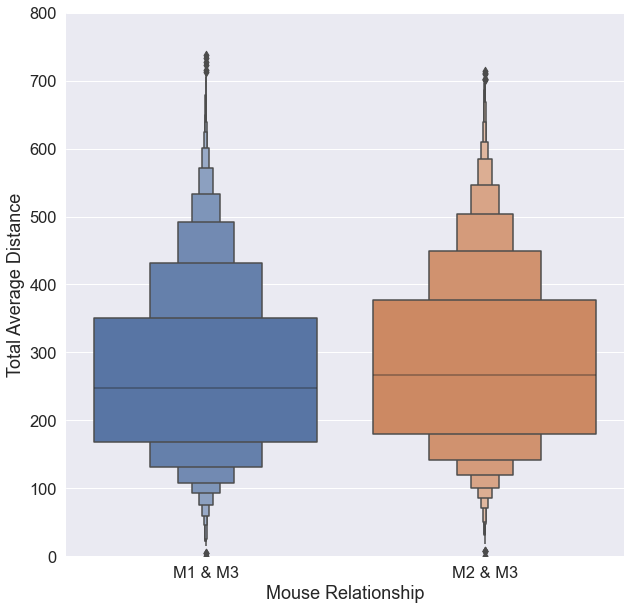

In [55]:
#Show the distributions of total average distancee between the different mice from the M3 prespective
plt.figure(figsize=(10,10))
ax = sns.set(font_scale=1.5)
ax = sns.boxenplot(x=epoch3_melt_distance_df['Relationship'].loc[45257:], #palette="dark", 
                   y='Average Distance',
                 data=epoch3_melt_distance_df, #order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H']
)

ax.set(ylim=(0, 800), xlabel= "Mouse Relationship", ylabel="Total Average Distance"
      )
sns.despine(left=True, bottom=True)

#plt.savefig(f'dlc_example_boxenplot.png', dpi=900, bbox_inches='tight')

In [ ]:
#For each pair in each experiment, 50pixel bins

#sns.displot(
#    df, x="flipper_length_mm", col="species", row="sex",
#    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
#)

#Average over all 5 experiments with SE


sns.histplot(epoch3_melt_distance_df, #x=epoch3_melt_distance_df['Relationship'], col="Average Distance", #row="sex",
    #binwidth=50, height=10, facet_kws=dict(margin_titles=True),
)

In [40]:
#average_distance_df.tail()
epoch3_melt_distance_df

,Frame,Relationship,Average Distance
0,18129,M1 & M2,342.038875
1,18130,M1 & M2,343.218750
2,18131,M1 & M2,344.610375
3,18132,M1 & M2,344.596125
4,18133,M1 & M2,344.865500
...,...,...,...
135766,27113,M2 & M3,103.665625
135767,27114,M2 & M3,104.060500
135768,27115,M2 & M3,100.171523
135769,27116,M2 & M3,100.088023


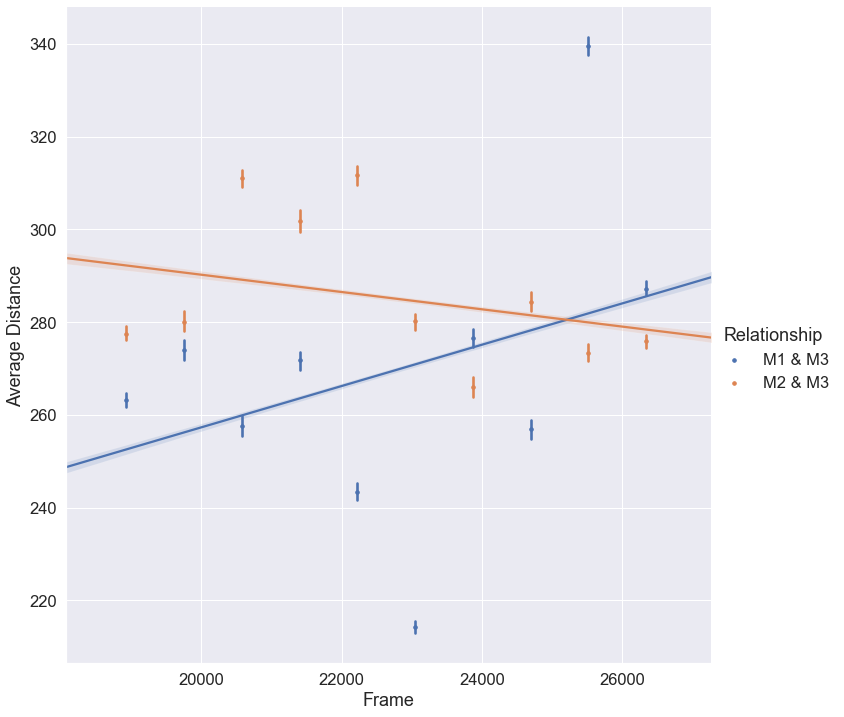

In [64]:
#Plotting only the M3 related data - how the distane of the M3's interactions change over the course of the video
sns.lmplot(x='Frame', y="Average Distance",data=epoch3_melt_distance_df.loc[45257:], hue="Relationship",
           markers='.',x_bins=10, ci=68,
           height=10
)
#plt.savefig(f'dlc_example_lmplot.png', dpi=900, bbox_inches='tight')

<AxesSubplot:xlabel='Frame', ylabel='Average Distance'>

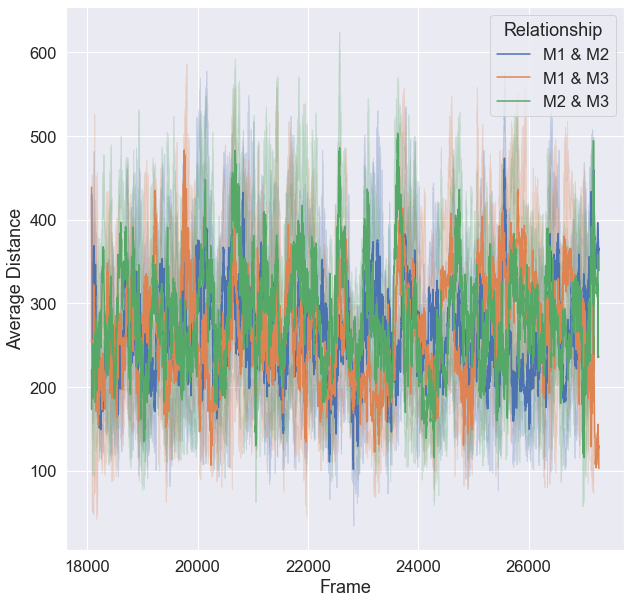

In [26]:
#plt.figure(figsize=(10,10))
#ax = sns.set(font_scale=1.5)
#sns.lineplot(x="Frame", y="Average Distance",
#             hue="Relationship", #style="event",
#            data=epoch3_melt_distance_df)
#plt.savefig(f'dlc_example_lineplot.png', dpi=900, bbox_inches='tight')

<AxesSubplot:xlabel='Frame', ylabel='Average Distance'>

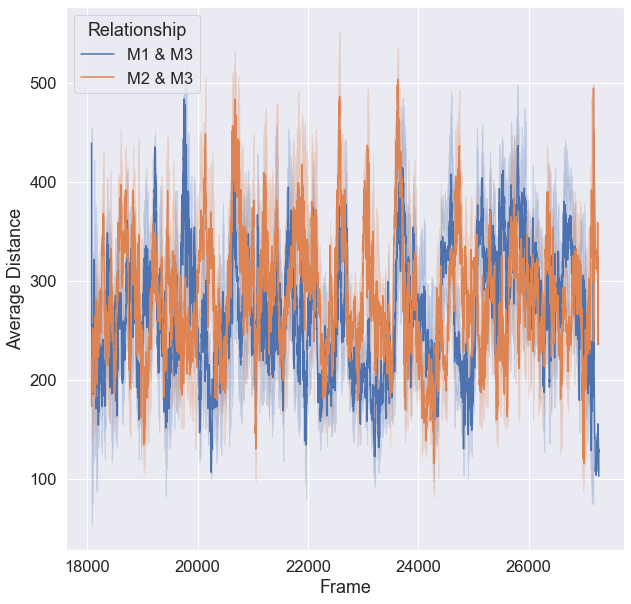

In [56]:
#Plotting only the M3 related data
plt.figure(figsize=(10,10))
ax = sns.set(font_scale=1.5)
sns.lineplot(x=epoch3_melt_distance_df['Frame'].loc[45257:], y=epoch3_melt_distance_df["Average Distance"].loc[45257:],
             hue="Relationship", #style="event",
             data=epoch3_melt_distance_df.loc[45257:],ci=68)
#plt.savefig(f'dlc_example_lineplot.png', dpi=900, bbox_inches='tight')

In [ ]:
#plt.figure(figsize=(10,10))
#ax = sns.set(font_scale=1.5)
#sns.lineplot(x="Frame", y="Average Distance",
#             hue="Relationship", #style="event",
#             data=epoch3_melt_distance_df)
#plt.savefig(f'dlc_example_lineplot.png', dpi=900, bbox_inches='tight')

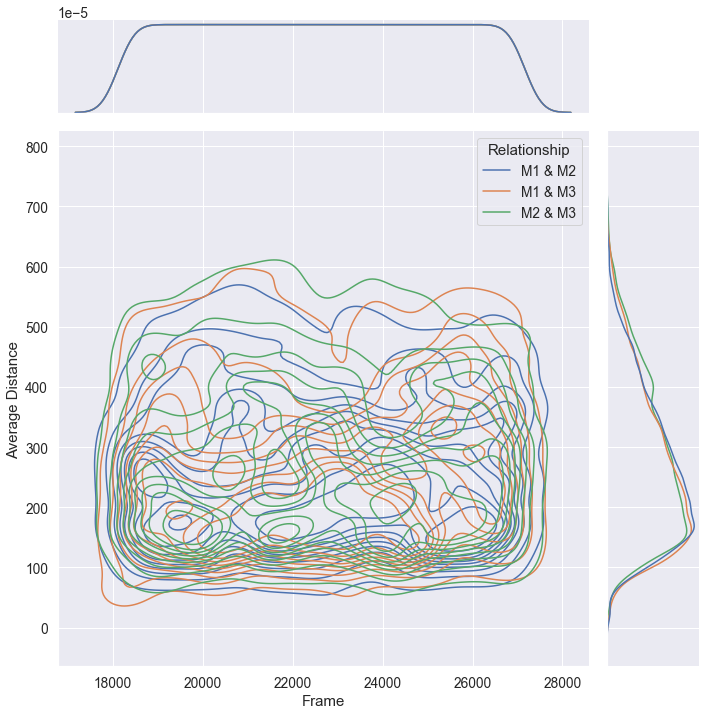

In [27]:
#Show the distributions of the mive average distances as a function of time
#ax = sns.set(font_scale=1.25)
#g = sns.jointplot(
    #data=epoch3_melt_distance_df,
    #x="Frame", y="Average Distance", hue="Relationship",
    #kind="kde", height = 10
#)

#plt.title('Average Positions of Mouse Distances')
#plt.savefig(f'dlc_example_regplot.png', dpi=900, bbox_inches='tight')

## Takeaways from Basic Viz for Third Epoch
    In every instance (albeit, without staatistics to backup what I can glean visually) there is really no difference in how close all the different animals are during the third epoch (when all three mice are present) for all five experiments. 

# Feild of View test

In [28]:
http://www.roguebasin.com/index.php?title=Permissive_Field_of_View_in_Python 

SyntaxError: invalid syntax (<ipython-input-28-564e0a1727b6>, line 1)